# Testing AudioMPS class

In [1]:
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

sys.path.append("../")

from model import RhoCMPS

In [2]:
sess = tf.InteractiveSession()

## Load Data

In [3]:
BATCH_SIZE = 32

In [4]:
guitar_dataset = tf.data.TFRecordDataset('../data/guitar.tfrecords')

In [5]:
parse_function = lambda example_proto: tf.parse_single_example(example_proto,
                                                               {"audio": tf.FixedLenFeature([2**16], dtype=tf.float32)})

In [6]:
guitar_dataset = guitar_dataset.map(parse_function)  # Parse the record into tensors.

In [7]:
guitar_dataset

<DatasetV1Adapter shapes: {audio: (65536,)}, types: {audio: tf.float32}>

In [8]:
guitar_dataset = guitar_dataset.batch(batch_size=BATCH_SIZE).shuffle(buffer_size=100).repeat()
guitar_iterator = guitar_dataset.make_one_shot_iterator()
guitar_batch = guitar_iterator.get_next()

In [9]:
guitar_batch['audio']

<tf.Tensor 'IteratorGetNext:0' shape=(?, 65536) dtype=float32>

An example waveform

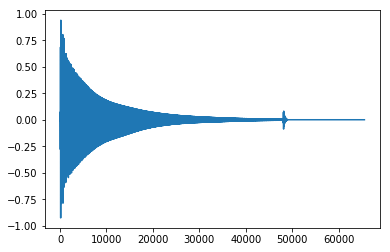

In [12]:
plt.plot(sess.run(guitar_batch['audio'])[0])

Close up

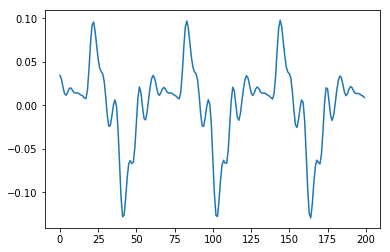

In [14]:
plt.plot(sess.run(guitar_batch['audio'])[0][20000:20200])

Here's the derivative

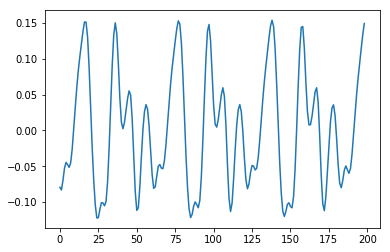

In [11]:
plt.plot(np.diff(sess.run(guitar_batch['audio'])[0][20000:20200]))

## Checking the loss works

In [12]:
BOND_D = 5

In [13]:
with tf.variable_scope("guitar_model"):
    guitar_model = AudioMPS(BOND_D, delta_t=0.01, data_iterator=guitar_batch['audio'])

In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
sess.run(guitar_model.loss)

2475.9924

## Training

### Damped sine wave with random time delay

In [78]:
tf.sign?

In [31]:
delays = tf.random_gamma([BATCH_SIZE], alpha=1, beta=None)

In [106]:
input_length = 2**12
BATCH_SIZE = 8
RANDOM_DELAY = True
freq = 0.05
decay_time = input_length / 4
delay_time = input_length / 400

with tf.variable_scope("sine_model_data", reuse=tf.AUTO_REUSE):
    delays = tf.stack(INPUT_LENGTH * [tf.random_gamma([BATCH_SIZE], alpha=2, beta=2/delay_time)], axis=-1)
    
    input_range = tf.expand_dims(tf.range(INPUT_LENGTH,dtype=np.float32), axis=0)
    times = input_range - delays
    sine_wave_random_delay = 0.5 * (tf.sign(times) + 1) * tf.sin(2 * np.pi * freq * times) * tf.exp(-times/decay_time)
    
    
    
    

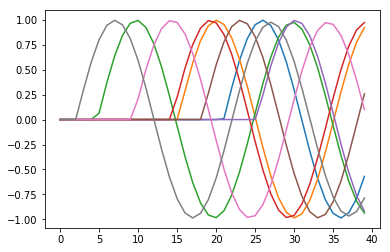

In [109]:
for wave in sess.run(sine_wave_random_delay):
    plt.plot(wave[:40])

In [18]:
BOND_D = 5
with tf.variable_scope("sine_model", reuse=tf.AUTO_REUSE):
    sine_model = AudioMPS(BOND_D, delta_t=0.01, data_iterator=sine_wave_random_phase)

NameError: name 'AudioMPS' is not defined

Try training with the TF training script... does everything for us.

First add some summaries that we will track during training

In [19]:
tf.summary.scalar("loss_function", tf.reshape(sine_model.loss, []))
tf.summary.audio("sample_inputs", sine_wave_random_phase, sample_rate=16000, max_outputs=1)

<tf.Tensor 'sample_inputs:0' shape=() dtype=string>

In [21]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(sine_model.loss, global_step=step)

ValueError: Variable global_step already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-20-448ad8913c60>", line 1, in <module>
    step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
  File "/Users/austenlamacraft/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/Users/austenlamacraft/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):


In [32]:
tf.contrib.training.train(train_op, logdir="../logging", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../logging/model.ckpt-894
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 894 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 954 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 0.995983
INFO:tensorflow:Saving checkpoints for 1015 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1076 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 1.00061
INFO:tensorflow:Saving checkpoints for 1137 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 0.999708
INFO:tensorflow:Saving checkpoints for 1197 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1256 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 0.986784
INFO:tensorflow:Saving checkpoints for 1316 into ../logging/model.ckpt.
INFO:tensorflow:Saving chec

KeyboardInterrupt: 

## Sampling 

Load the trained model into the current session.

In [33]:
BOND_D = 5
with tf.variable_scope("sine_model", reuse=tf.AUTO_REUSE):
    sample_sine = AudioMPS(BOND_D, delta_t=0.01)

In [34]:
ckpt_state = tf.train.get_checkpoint_state("../logging/")

In [35]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../logging/model.ckpt-1617


In [36]:
samples = sample_sine.sample(5,1000,temp=0.000001)

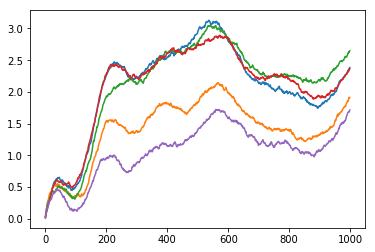

In [37]:
for sample in sess.run(samples):
    plt.plot(sample)